In [1]:
cd ..

m:\OneDrive\Projects\federated_imputation_pc2


In [2]:
import pandas as pd
from src.modules.data_preprocessing import load_data
import seaborn as sns
import matplotlib.pyplot as plt

## Correlation

(13008, 26)


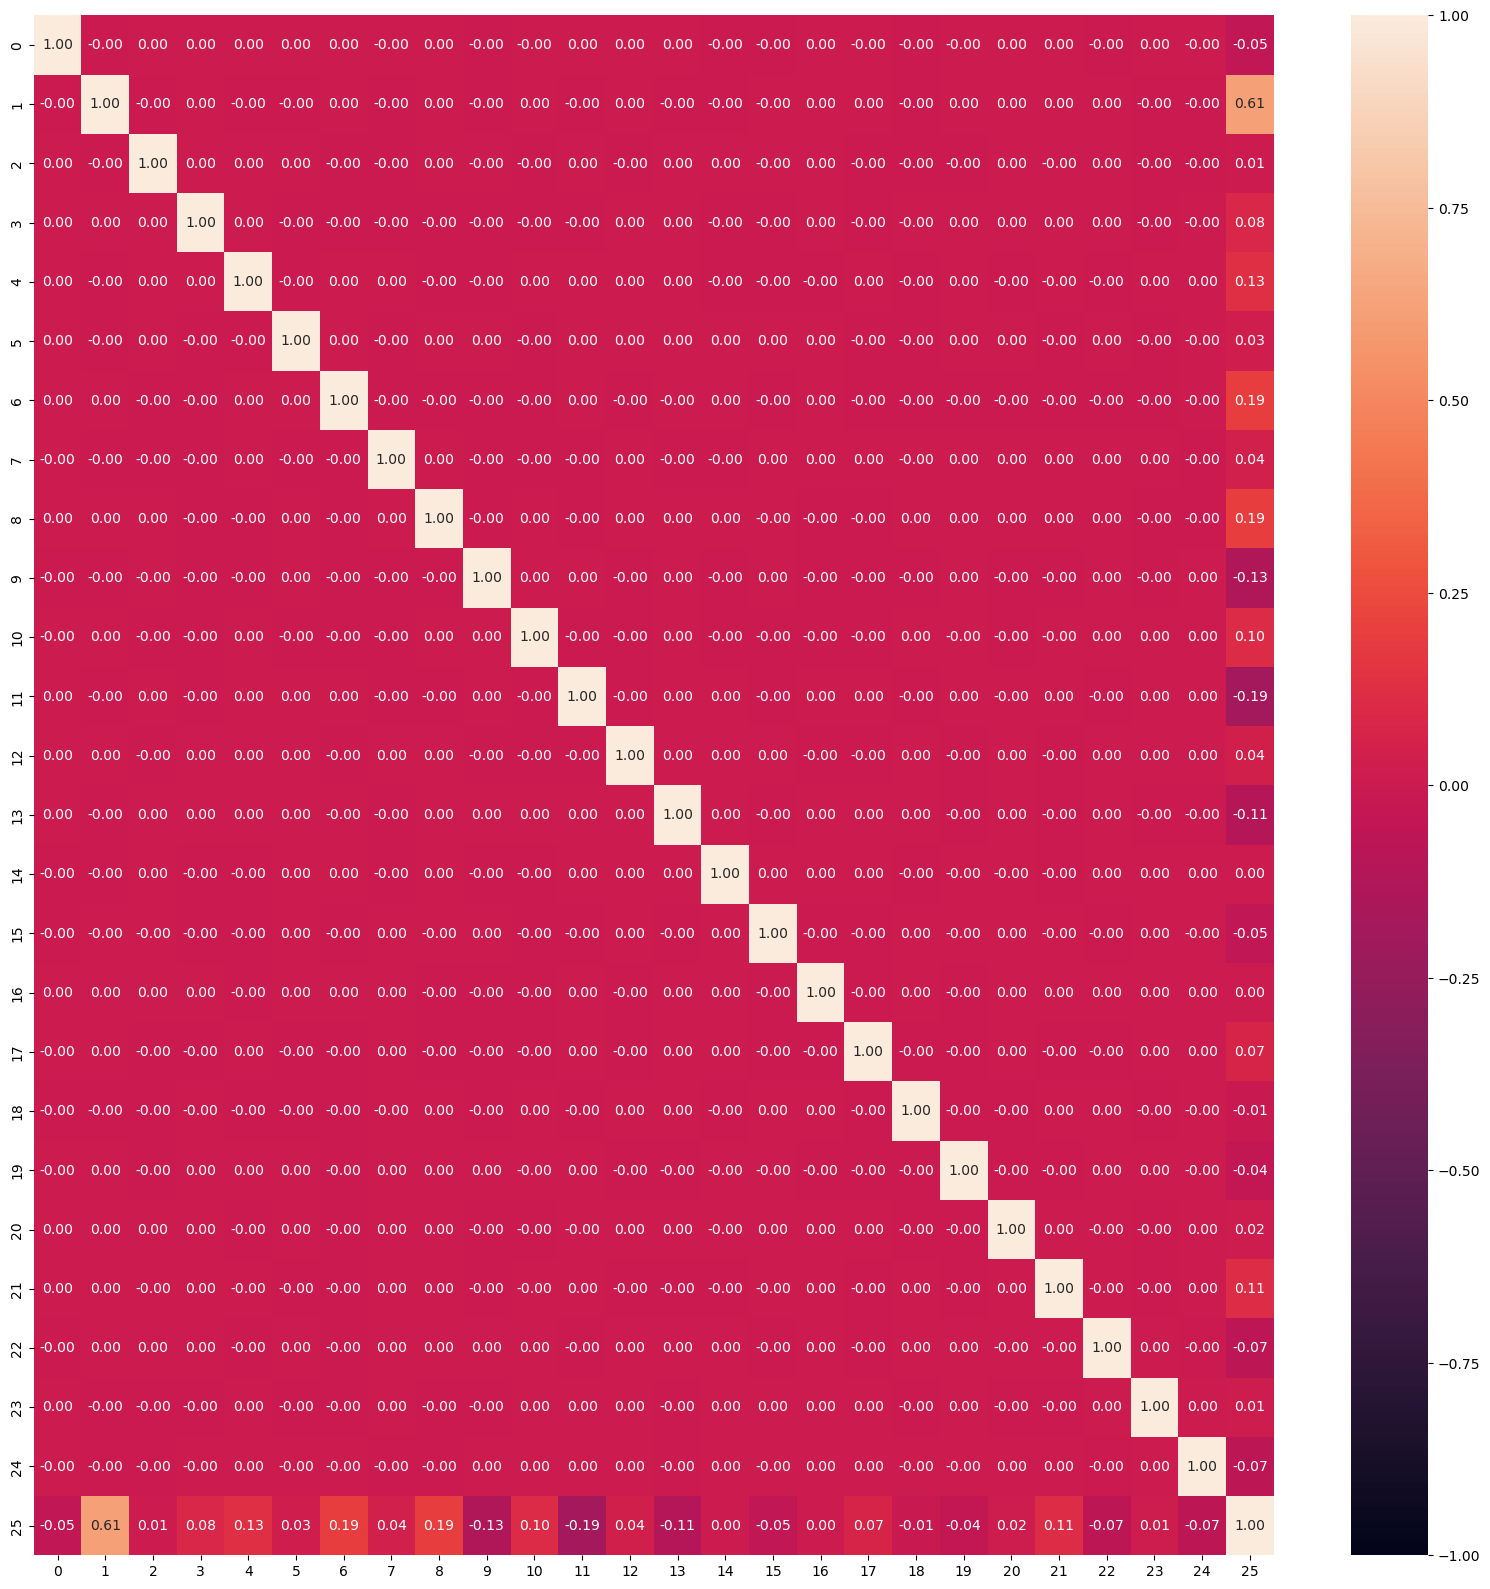

In [3]:
codon, _ = load_data('codon')

plt.figure(figsize=(20, 20))
heatmap = sns.heatmap(codon.corr(), vmin=-1, vmax=1, annot=True, fmt = ".2f" )
plt.show()

m:\miniconda3\envs\fed_imp\lib\site-packages\dython\nominal.py:293: RuntimeWarning: Rounded eta = 1.0000000000000002 to 1. This is probably due to floating point precision issues.
  warnings.warn(


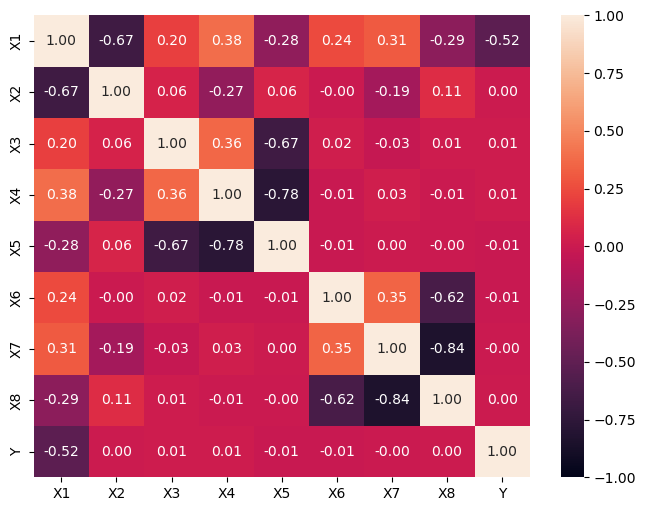

In [16]:
codrna, _ = load_data('codrna')

plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(codrna.corr(), vmin=-1, vmax=1, annot=True, fmt = ".2f" )
plt.show()

(20000, 51)
mortality
0    14556
1     5444
Name: count, dtype: int64


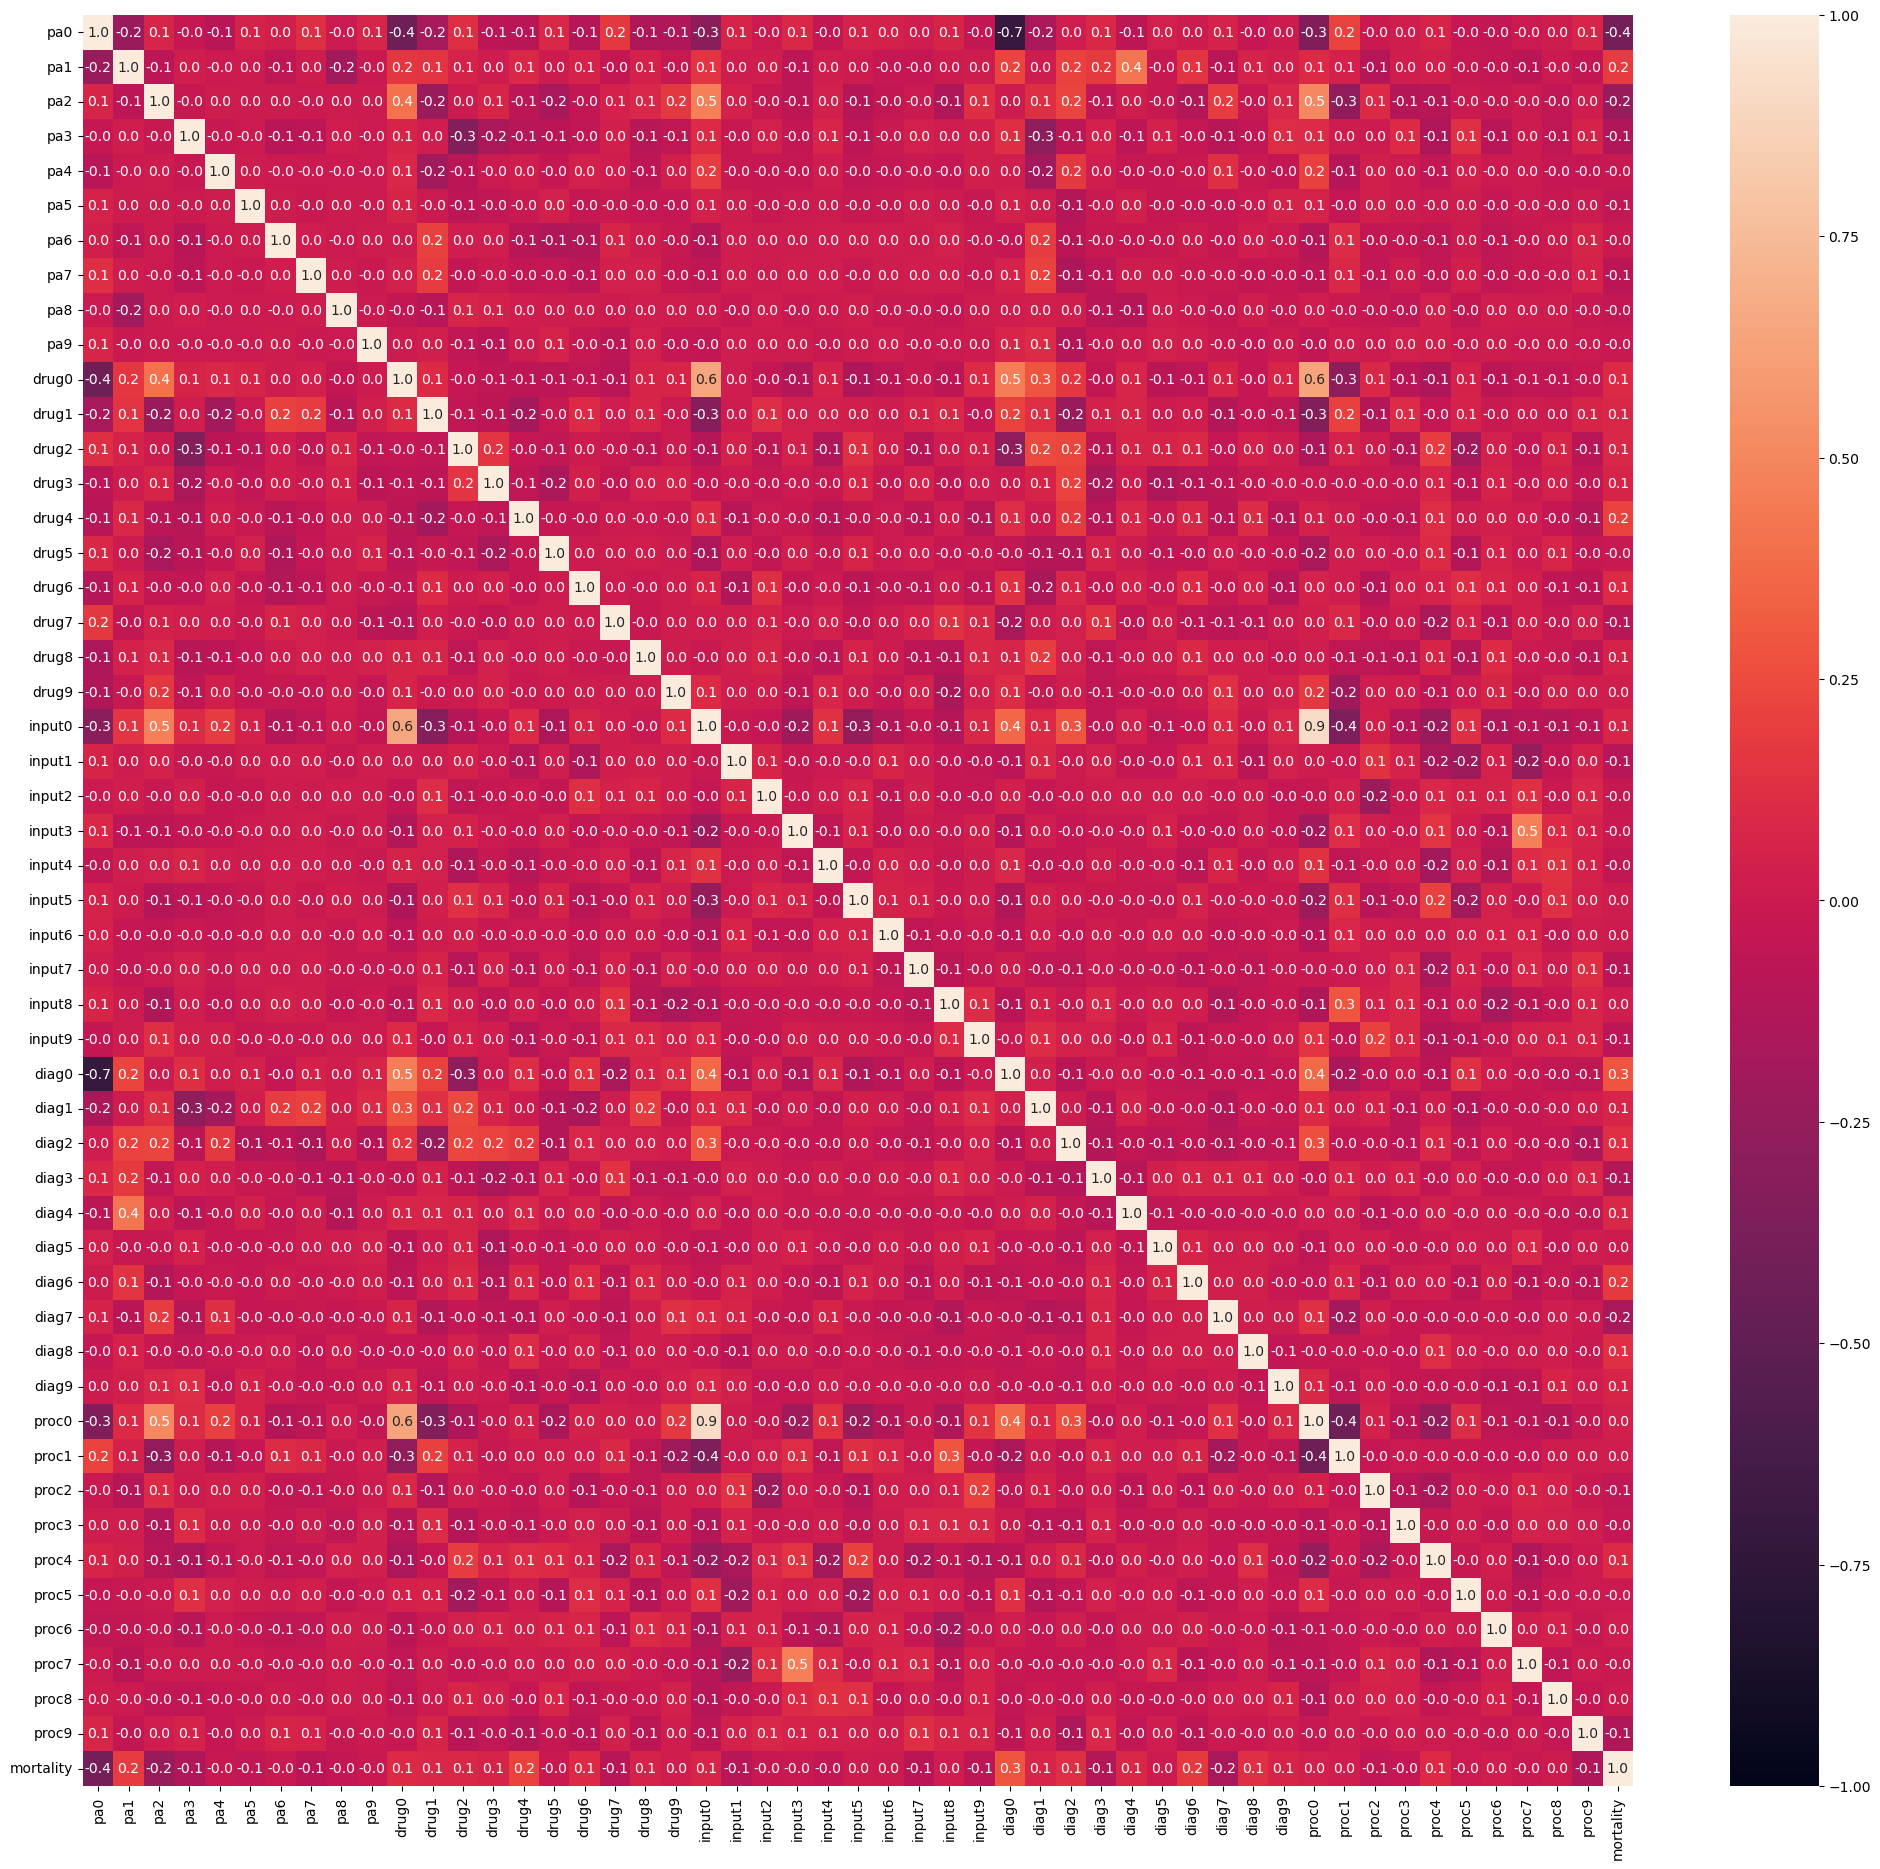

In [19]:
mimiciii_mo, _ = load_data('mimiciii_mo2')

plt.figure(figsize=(25, 23))
heatmap = sns.heatmap(mimiciii_mo.corr(), vmin=-1, vmax=1, annot=True, fmt = ".1f" )
plt.show()

['BMI', 'PhysicalHealth', 'MentalHealth', 'SleepTime']
(319795, 25)
(20000, 25)


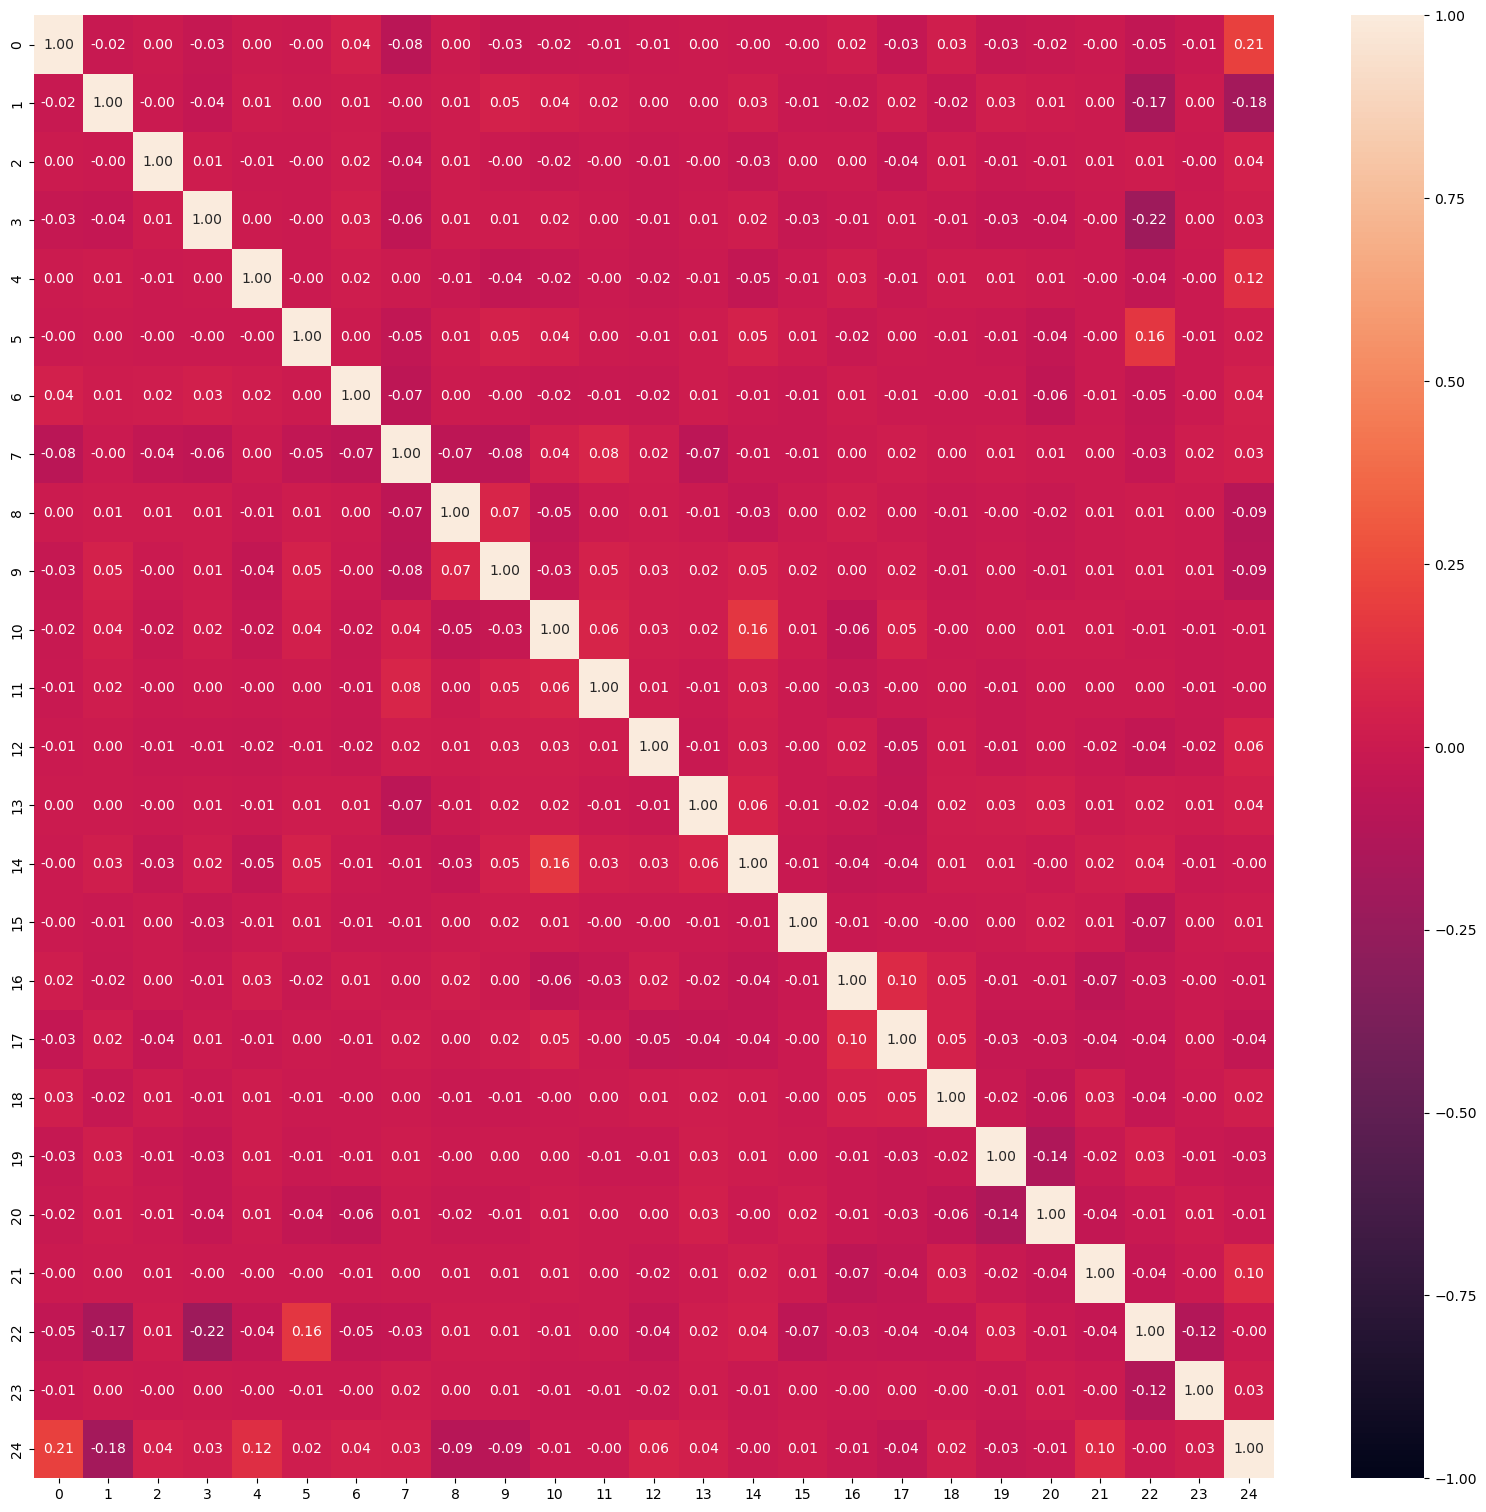

In [22]:
heart, _ = load_data('heart')

plt.figure(figsize=(20, 19))
heatmap = sns.heatmap(heart.corr(), vmin=-1, vmax=1, annot=True, fmt = ".2f" )
plt.show()

Index(['CLNDISDBINCL', 'CLNDNINCL', 'CLNSIGINCL', 'SSR', 'DISTANCE',
       'MOTIF_NAME', 'MOTIF_POS', 'HIGH_INF_POS', 'MOTIF_SCORE_CHANGE'],
      dtype='object')
(65188, 217)
(65188, 12)
(65188, 230)
(20000, 33)
CLASS
0    15007
1     4993
Name: count, dtype: int64


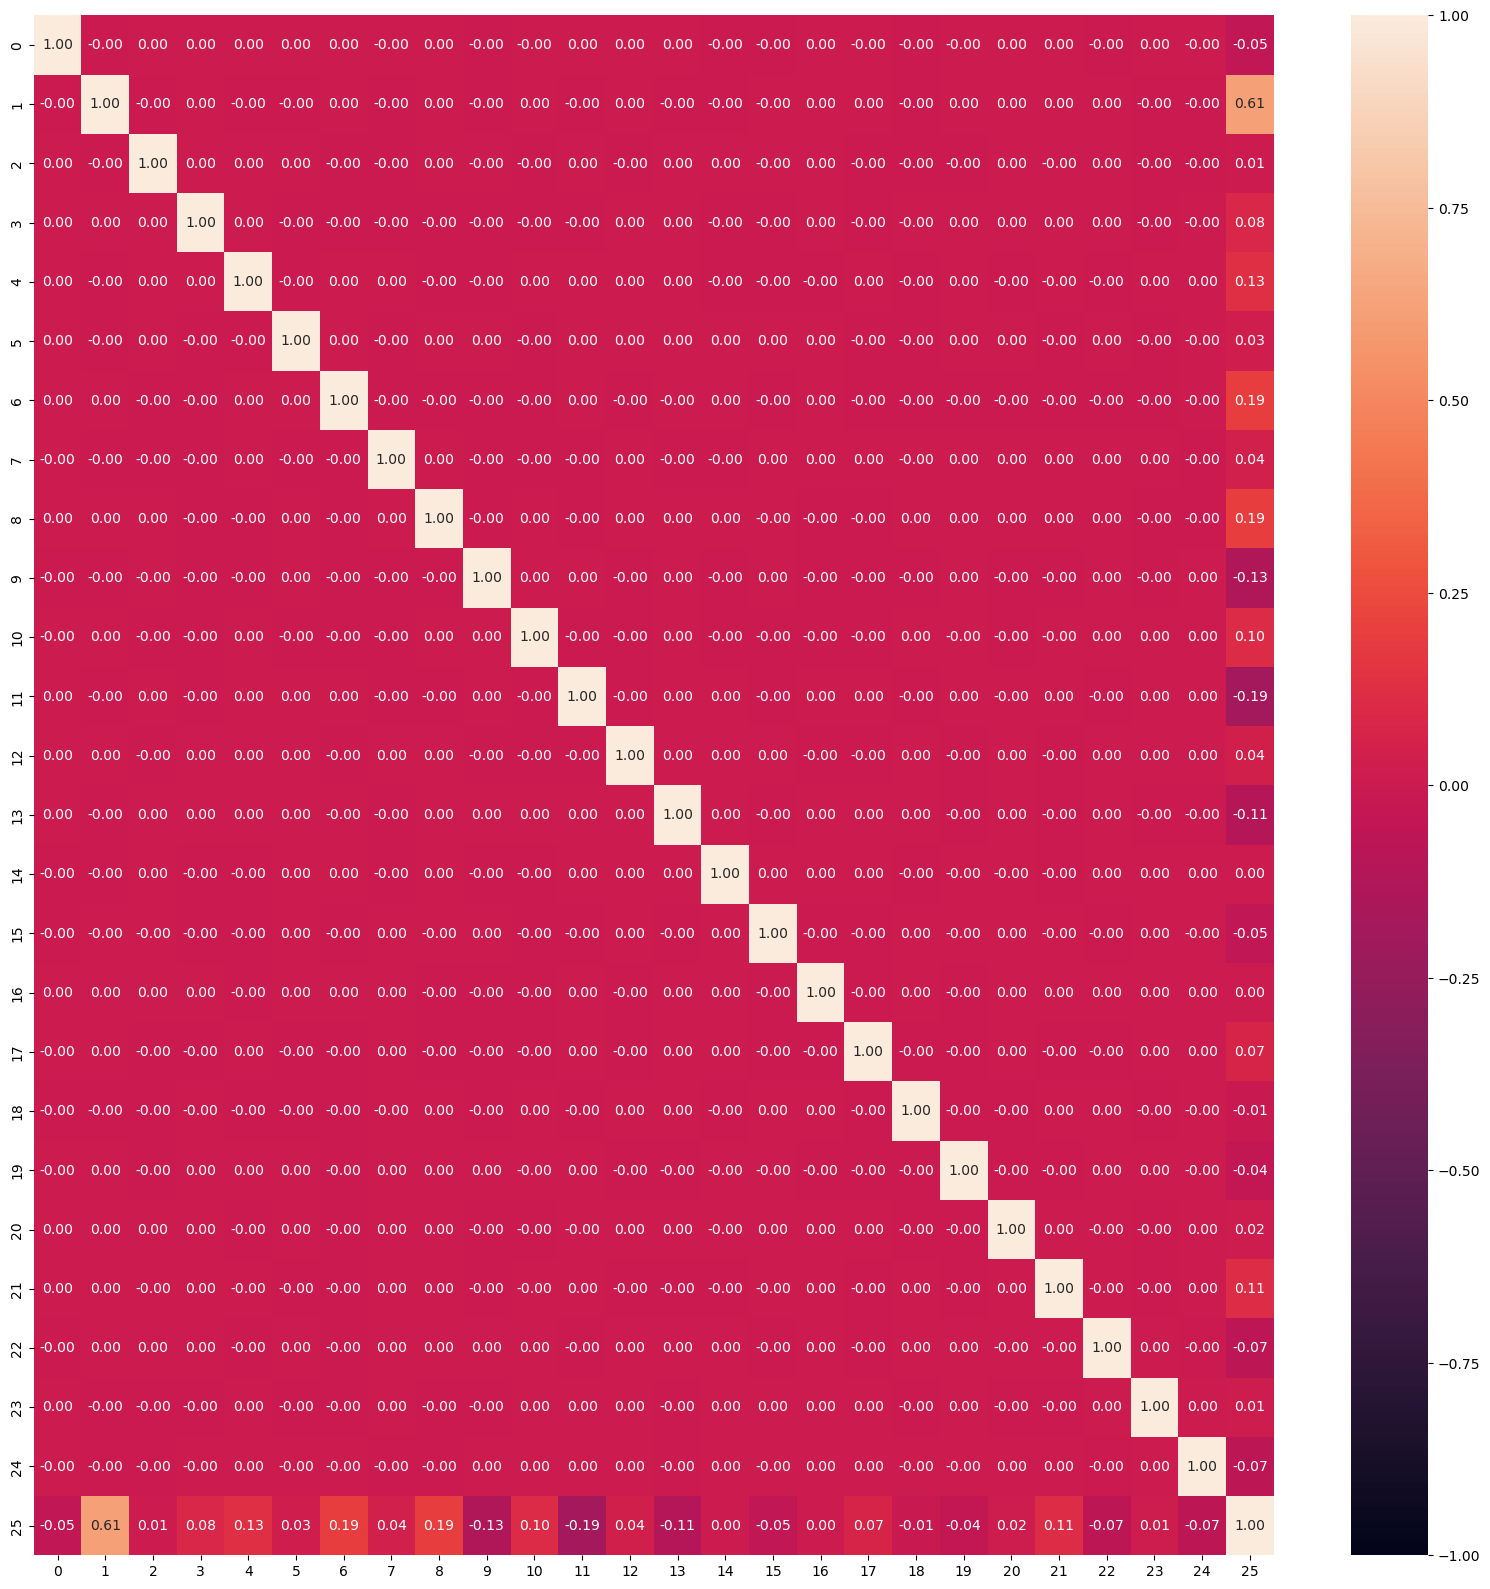

In [23]:
genetic, _ = load_data('genetic')

plt.figure(figsize=(20, 20))
heatmap = sns.heatmap(codon.corr(), vmin=-1, vmax=1, annot=True, fmt = ".2f" )
plt.show()

## Logistic MNAR - m1

In [146]:
import torch
import numpy as np
from scipy import optimize
from scipy.special import expit
from typing import List

def MNAR_self_mask_logistic(X, p):
    """
    Missing not at random mechanism with a logistic self-masking model. Variables have missing values probabilities
    given by a logistic model, taking the same variable as input (hence, missingness is independent from one variable
    to another). The intercepts are selected to attain the desired missing rate.

    Parameters
    ----------
    X : torch.DoubleTensor or np.ndarray, shape (n, d)
        Data for which missing values will be simulated.
        If a numpy array is provided, it will be converted to a pytorch tensor.

    p : float
        Proportion of missing values to generate for variables which will have missing values.

    Returns
    -------
    mask : torch.BoolTensor or np.ndarray (depending on type of X)
        Mask of generated missing values (True if the value is missing).

    """

    n, d = X.shape

    to_torch = torch.is_tensor(X) ## output a pytorch tensor, or a numpy array
    if not to_torch:
        X = torch.from_numpy(X)

    ### Variables will have NA proportions that depend on those observed variables, through a logistic model
    ### The parameters of this logistic model are random.

    ### Pick coefficients so that W^Tx has unit variance (avoids shrinking)
    coeffs = pick_coeffs(X, self_mask=True)
    ### Pick the intercepts to have a desired amount of missing values
    intercepts = fit_intercepts(X, coeffs, p, self_mask=True)

    ps = torch.sigmoid(X * coeffs + intercepts)

    ber = torch.rand(n, d) if to_torch else np.random.rand(n, d)
    mask = ber < ps if to_torch else ber < ps.numpy()

    return mask

def pick_coeffs(
    X: np.ndarray,
    idxs_obs: List[int] = [],
    idxs_nas: List[int] = [],
    self_mask: bool = False,
) -> np.ndarray:
    n, d = X.shape
    if self_mask:
        coeffs = np.random.rand(d)
        Wx = X * coeffs
        coeffs /= np.std(Wx, 0)
    else:
        d_obs = len(idxs_obs)
        d_na = len(idxs_nas)
        coeffs = np.random.rand(d_obs, d_na)
        np.fill_diagonal(coeffs, 5)
        Wx = X[:, idxs_obs] @ coeffs
        coeffs /= np.std(Wx, 0, keepdims=True)
    return coeffs


def fit_intercepts(
    X: np.ndarray, coeffs: np.ndarray, p: float, self_mask: bool = False
) -> np.ndarray:
    if self_mask:
        d = len(coeffs)
        intercepts = np.zeros(d)
        for j in range(d):

            def f(x: np.ndarray) -> np.ndarray:
                return expit(X * coeffs[j] + x).mean().item() - p

            intercepts[j] = optimize.bisect(f, -50, 50)
    else:
        d_obs, d_na = coeffs.shape
        intercepts = np.zeros(d_na)
        for j in range(d_na):

            def f(x: np.ndarray) -> np.ndarray:
                return np.quantile(expit(-np.dot(X, coeffs[:, j]) + x), p) - p

            intercepts[j] = optimize.bisect(f, -50, 50)
    return intercepts


def MNAR_mask_logistic(
    X: np.ndarray, p: float, p_params: float = 0.3, exclude_inputs: bool = True
) -> np.ndarray:
    """
    Missing not at random mechanism with a logistic masking model. It implements two mechanisms:
    (i) Missing probabilities are selected with a logistic model, taking all variables as inputs. Hence, values that are
    inputs can also be missing.
    (ii) Variables are split into a set of intputs for a logistic model, and a set whose missing probabilities are
    determined by the logistic model. Then inputs are then masked MCAR (hence, missing values from the second set will
    depend on masked values.
    In either case, weights are random and the intercept is selected to attain the desired proportion of missing values.

    Args:
        X : Data for which missing values will be simulated.
        p : Proportion of missing values to generate for variables which will have missing values.
        p_params : Proportion of variables that will be used for the logistic masking model (only if exclude_inputs).
        exclude_inputs : True: mechanism (ii) is used, False: (i)

    Returns:
        mask : Mask of generated missing values (True if the value is missing).

    """

    n, d = X.shape

    mask = np.zeros((n, d)).astype(bool)

    d_params = (
        max(int(p_params * d), 1) if exclude_inputs else d
    )  # number of variables used as inputs (at least 1)
    d_na = (
        d - d_params if exclude_inputs else d
    )  # number of variables masked with the logistic model

    # Sample variables that will be parameters for the logistic regression:
    idxs_params = (
        np.random.choice(d, d_params, replace=False) if exclude_inputs else np.arange(d)
    )
    idxs_nas = (
        np.array([i for i in range(d) if i not in idxs_params])
        if exclude_inputs
        else np.arange(d)
    )

    # Other variables will have NA proportions selected by a logistic model
    # The parameters of this logistic model are random.

    # Pick coefficients so that W^Tx has unit variance (avoids shrinking)
    coeffs = pick_coeffs(X, idxs_params, idxs_nas)
    # Pick the intercepts to have a desired amount of missing values
    intercepts = fit_intercepts(X[:, idxs_params], coeffs, p)

    ps = expit(-X[:, idxs_params] @ coeffs + intercepts)

    # ber = np.random.rand(n, d_na)
    # mask[:, idxs_nas] = ber < ps
    mask[:, idxs_nas] = ps > p

    # If the inputs of the logistic model are excluded from MNAR missingness,
    # mask some values used in the logistic model at random.
    # This makes the missingness of other variables potentially dependent on masked values

    if exclude_inputs:
        mask[:, idxs_params] = np.random.rand(n, d_params) < p

    return mask, ps

$M = logit(\beta_1 X_1 + \beta_2 X_2 ... + \beta_k X_k + intercept)$

1. Increase beta_1  to make it have more influence to missing indicator
2. Limit the number of features used in logit function, so reduce noise from other feature
3. Set beta to be same sign with correlation between features which will make it consistent with the direction of logit function
4. Output of logit, we can make it to be not probabilistic, but determinstic


**Strategies for setting coeffs of logit model:**
- **b1**: set $\beta_1$ to be 1.0, set other $\beta$s randomly based on correlation (ri) of features `(0, ri)`
- **b2**: set $\beta_1$ to be fixed a large number (e.g. 5.0), set other $\beta$s randomly from `(0, 1)`
- **sphere**: sample $\beta$s from upper and lower cone of sphere, within certain degree of angle (e.g. 30 degree)
- **sphere2**: randonly pick a unit vector in sphere and its opposite unit vector, randomly assign $\beta$s of each client to one of the unit vector

**Limit number of $beta$s**: select proportional of correlated features (e.g. 25\%) to use in logit function


<Axes: ylabel='Count'>

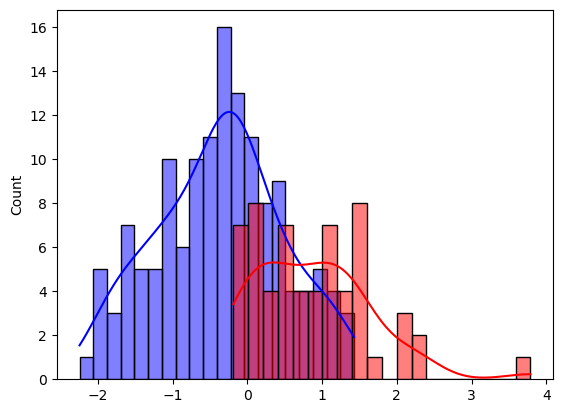

In [152]:
# distribution check
import seaborn as sns

X = np.random.randn(200, 50)
X = (X - np.mean(X, axis=0))/ np.std(X, axis=0)
corr_matrix = np.corrcoef(X, rowvar=False)

mask, ps = MNAR_mask_logistic(X, 0.3, 0.3, False)
sns.histplot(X[:, 0][mask[:, 0]], kde=True, color="blue", label="X", bins = 20)
sns.histplot(X[:, 0][~mask[:, 0]], kde=True, color="red", label="X", bins = 20)

<Axes: ylabel='Count'>

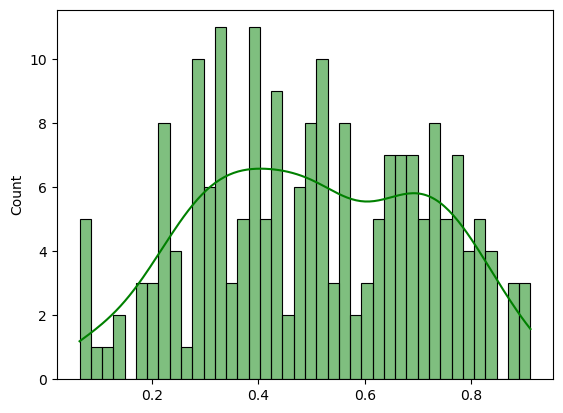

In [138]:
sns.histplot(ps[:, 0], kde=True, color="green", label="ps", bins = 40)

In [123]:
from sklearn.feature_selection import mutual_info_regression

X_col = X[:, 4]
mi = mutual_info_regression(X, X_col)
mi_idx = np.argsort(mi)[::-1]
print(mi, mi_idx)
data_corr = X[:, mi_idx]
data_corr[0]

[0.03983225 0.06454187 0.         0.         4.03969761] [4 1 0 3 2]


array([-0.22827454, -0.64273284, -1.16442383, -0.43519827, -0.34488955])

In [115]:
import n_sphere

def generate_param_vector(d, main_strength = 30, direction = 'up'):
    
    # sampling a vector from unit sphere
    if direction == 'up':
        theta_1 = np.random.uniform(0, main_strength)
    else:
        theta_1 = np.random.uniform(180-main_strength, 180)
    if d < 3:
        return n_sphere.convert_rectangular([1, np.radians(theta_1)])
    else:
        theta_others = []
        for i in range(d-3):
            theta_others.append(np.random.uniform(0, 90))
        theta_last = np.random.uniform(0, 360)
        thetas = [theta_1] + theta_others + [theta_last]
        thetas = [np.radians(theta) for theta in thetas]
        sphere_coords = [1] + thetas
        return n_sphere.convert_rectangular(sphere_coords)

coeffs = generate_param_vector(5, direction = 'down')
print(coeffs)
ps = expit(X @ coeffs + 0)
print((ps > 0.5).sum()/ps.shape[0])

[-0.934536, 0.355772, 0.002347, 0.007748, 0.001542]
0.495


## Result Debugging

In [204]:
def show_feature_dist(path, fid):
    mask = np.load(path + "missing_mask_0.npy")
    data = np.load(path + "origin_data_0.npy")
    split_indices = np.load(path + "split_indices_0.npy")

    masks = np.split(mask, split_indices)
    datas = np.split(data, split_indices)

    fid = 0
    cid = 7
    X = datas[cid]
    mask = masks[cid]
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    for cid in range(10):
        X = datas[cid]
        mask = masks[cid]
        sns.histplot(X[:, fid][mask[:, fid]], kde=True, color="blue", label="X", bins = 20, ax = axes[cid//5, cid%5])
        sns.histplot(X[:, fid][~mask[:, fid]], kde=True, color="red", label="X", bins = 20, ax = axes[cid//5, cid%5])

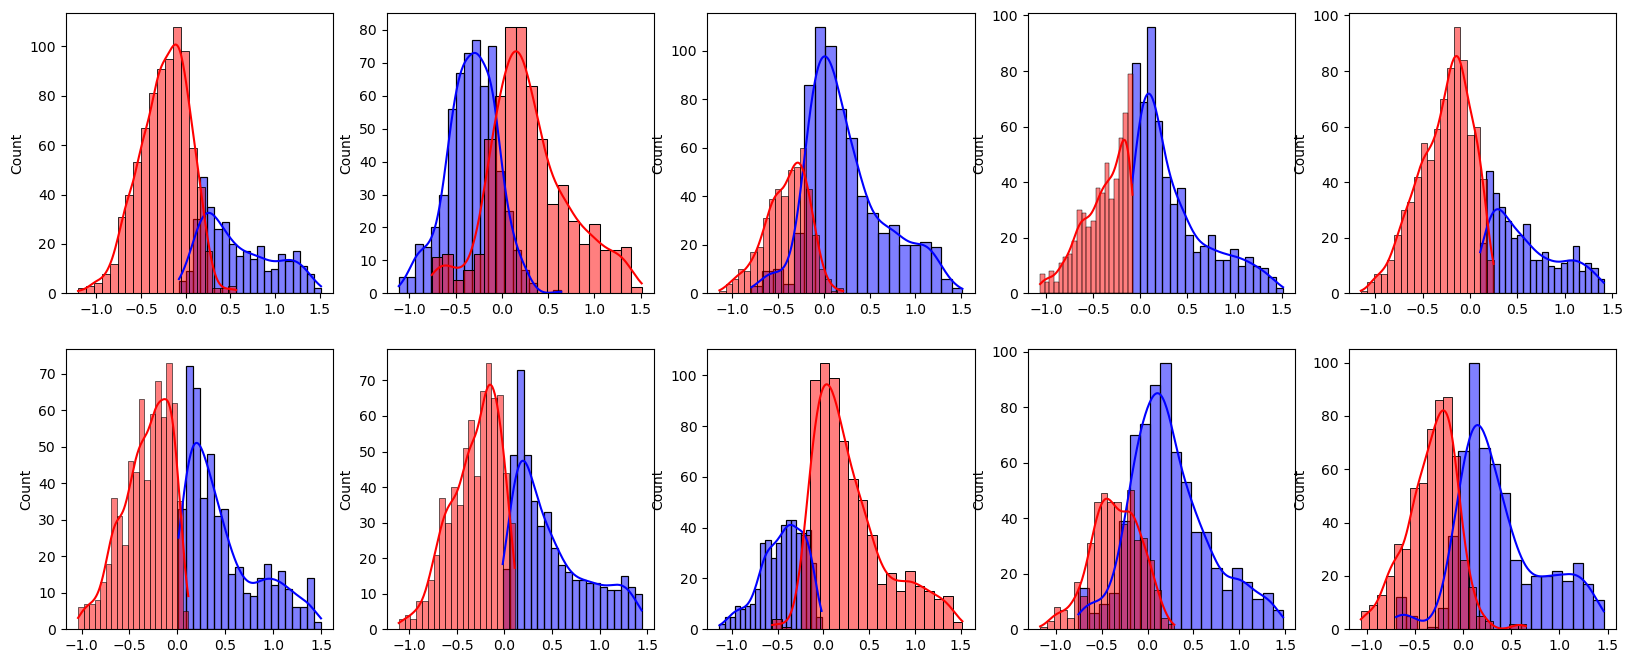

In [210]:
# no random sampling, sphere coefficients

path = "M:\\OneDrive\\Projects\\federated_imputation_pc2\\results\\"\
"raw_results\\fed_imp_ext_pc2\\0214\codon\\10\\sample-evenly\\random2@mrl=0.3_mrr=0.7_mm=mnarlrsigst"\
    "\\allk0.25_sphere\\as_fedavg-s@s_102931466@s_50@p_False\\"

show_feature_dist(path, 0)

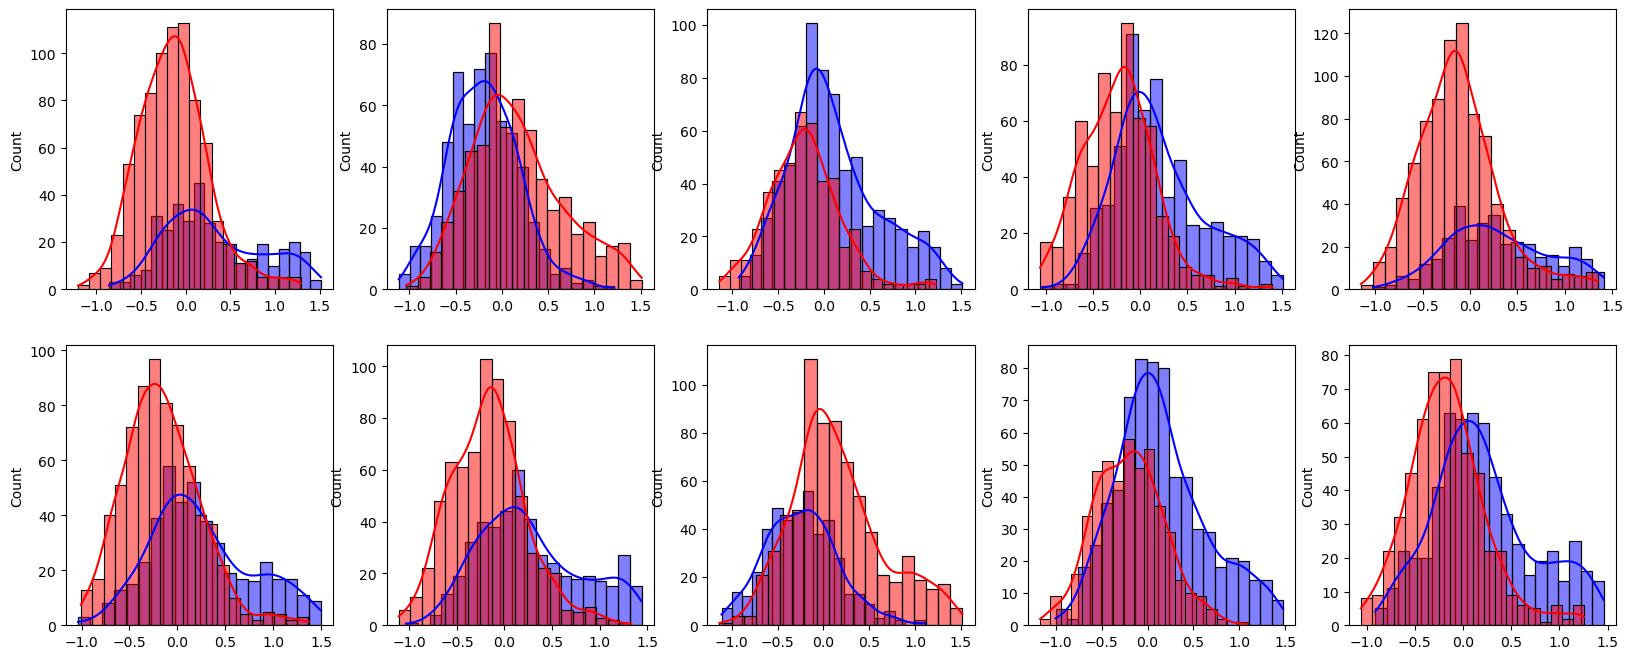

In [206]:
# random sampling, sphere coefficients

path = "M:\\OneDrive\\Projects\\federated_imputation_pc2\\results\\"\
"raw_results\\fed_imp_ext_pc2\\0214\codon\\10\\sample-evenly\\random2@mrl=0.3_mrr=0.7_mm=mnarlrsig"\
    "\\allk0.25_sphere\\as_fedavg-s@s_102931466@s_50@p_False\\"


show_feature_dist(path, 0)

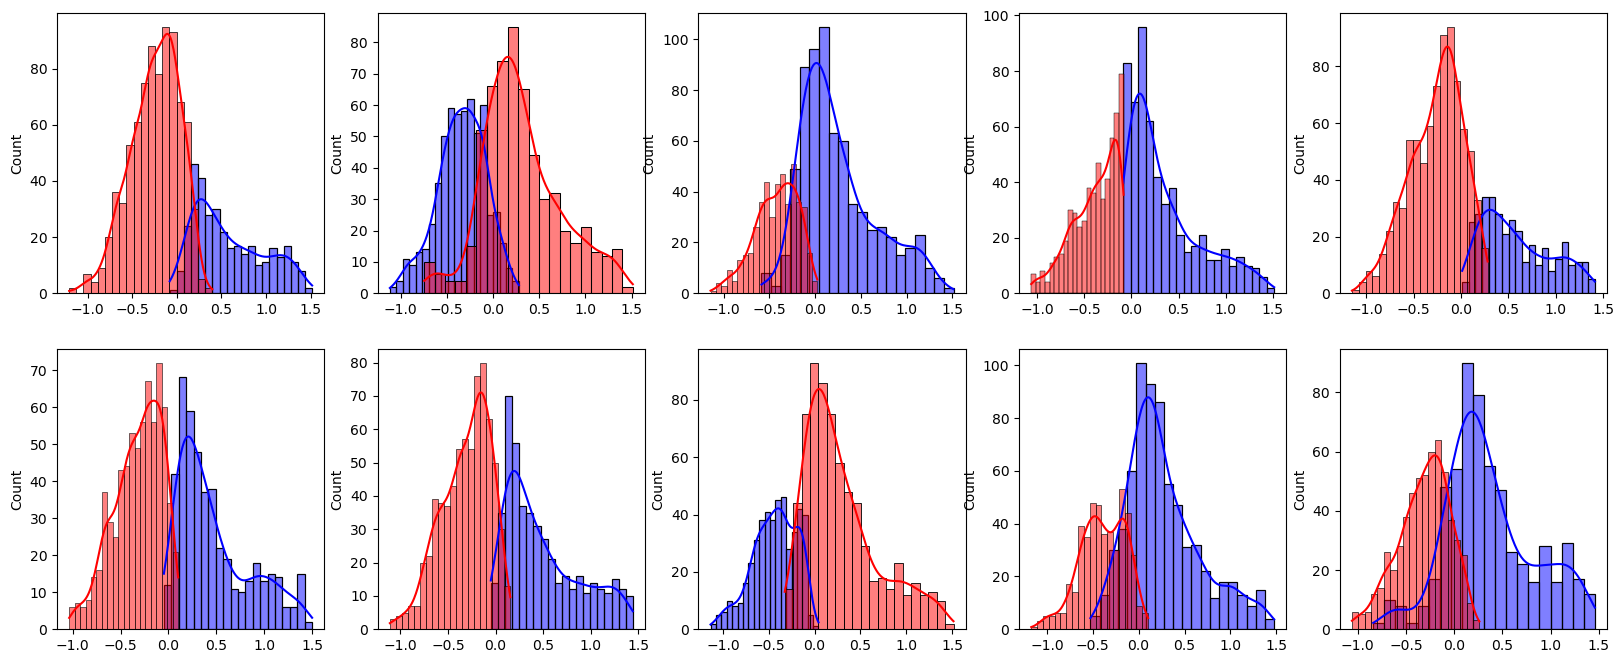

In [215]:
path = "M:\\OneDrive\\Projects\\federated_imputation_pc2\\results\\"\
"raw_results\\fed_imp_ext_pc2\\0214\codon\\10\\sample-evenly\\random2@mrl=0.3_mrr=0.7_mm=mnarlrsigst"\
    "\\all_sphere\\as_fedavg-s@s_102931466@s_50@p_False\\"


show_feature_dist(path, 0)

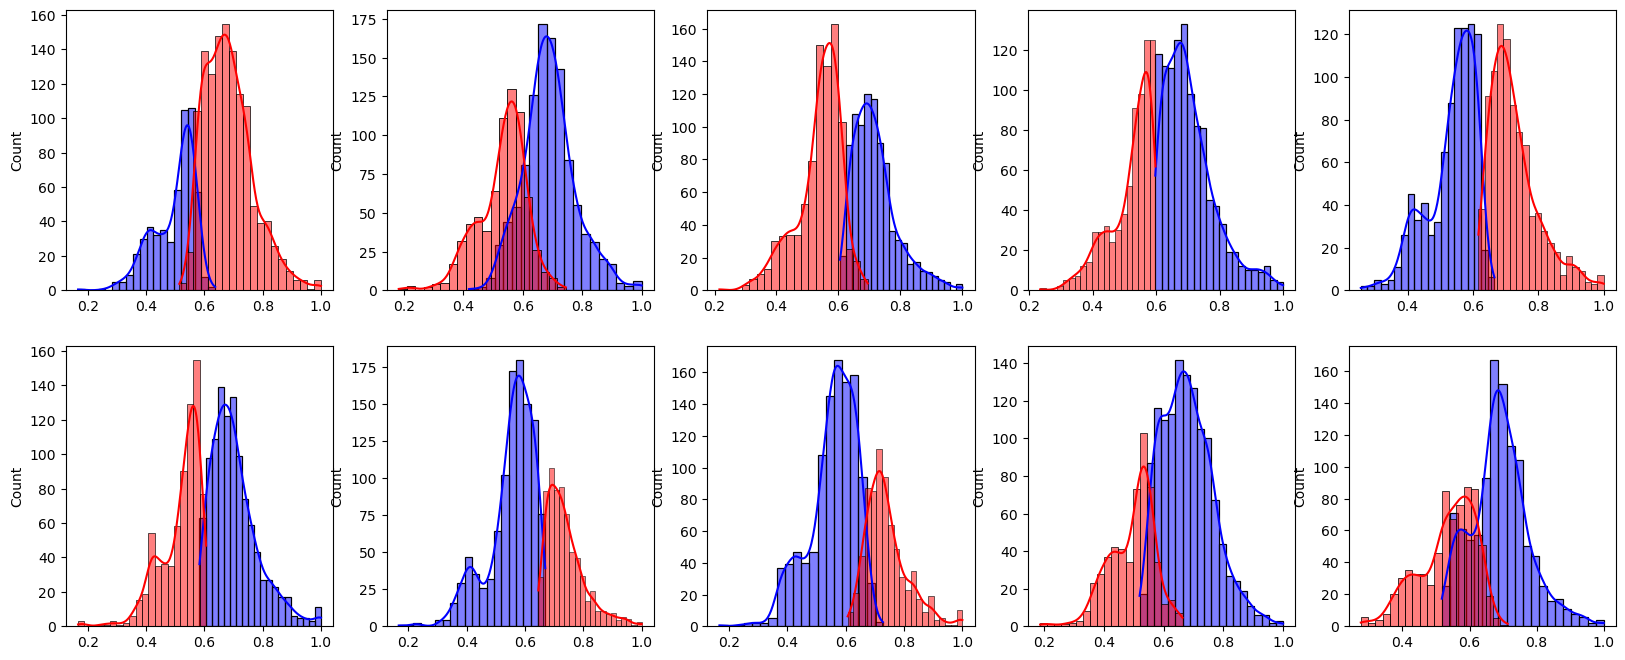

In [220]:
path = "M:\\OneDrive\\Projects\\federated_imputation_pc2\\results\\"\
"raw_results\\fed_imp_ext_pc2\\0214\codrna\\10\\sample-evenly\\random2@mrl=0.3_mrr=0.7_mm=mnarlrsigst"\
    "\\allk0.25_sphere\\as_fedavg-s@s_102931466@s_50@p_False\\"


show_feature_dist(path, 0)

In [233]:
import itertools
import json
dataset = ['codrna']
mechanism = ['mnarlrsigst', 'mnarlrsig']
method = ['central', 'local', 'fedavg-s', 'fedmechw_new']
coeff = [
    'all', 'all_b1', 'all_b2', 'all_sphere',
    'allk0.25', 'allk0.25_b1', 'allk0.25_b2', 'allk0.25_sphere', 
]

results = []
for d, m, s, c in itertools.product(dataset, mechanism, method, coeff):
    path = f"M:\\OneDrive\\Projects\\federated_imputation_pc2\\results\\"\
    f"raw_results\\fed_imp_ext_pc2\\0214\{d}\\10\\sample-evenly\\random2@mrl=0.3_mrr=0.7_mm={m}"\
        f"\\{c}\\as_{s}@s_102931466@s_50@p_False.json"
    
    with open(path, 'r') as f:
        data = json.load(f)
        results.append({
            'dataset': d, 'mechanism': m, 'coeff': c, 'method': s,
            "rmse": data['results']['avg_imp_final']['imp@rmse'],
            'sliced_ws': data['results']['avg_imp_final']['imp@sliced_ws'],
            'global_ws': data['results']['avg_imp_final']['imp@global_ws'],
        })

results = pd.DataFrame(results)
results['mechanism'] = pd.Categorical(results['mechanism'], categories=['mnarlrsigst', 'mnarlrsig'])
results['coeff'] = pd.Categorical(results['coeff'], categories=coeff)
results.sort_values(by=['mechanism', 'coeff'], inplace=True)
results.to_excel("./results/processed_results/codrna_ext.xlsx", index=False, sheet_name='codrna')

## Illustration

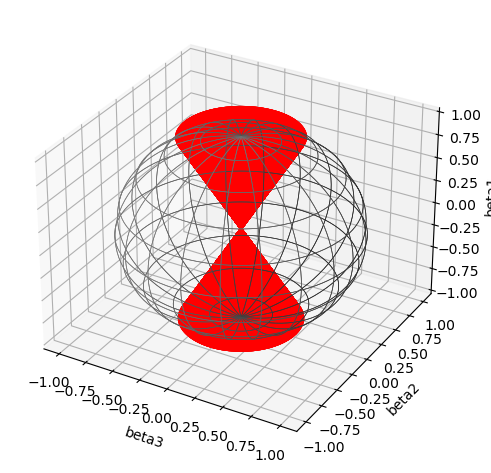

In [257]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Sphere parameters
radius = 1
phi, theta = np.mgrid[0.0:2.0*np.pi:100j, 0.0:np.pi:50j]

# Sphere coordinates
x = radius*np.sin(theta)*np.cos(phi)
y = radius*np.sin(theta)*np.sin(phi)
z = radius*np.cos(theta)

# Plotting
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the sphere
ax.plot_surface(x, y, z, alpha=0, edgecolors='grey', rstride=5, cstride=5, lw=0.5)

cone_height = 1  # Height of the cone (from center to tip)
cone_radius = 0.5  # Radius of the cone at its base
cone_resolution = 1000  # Number of points to plot for the cone
cone_phi = np.linspace(0, 2 * np.pi, cone_resolution)

# Cone coordinates
cone_x = cone_radius * np.cos(cone_phi)
cone_y = cone_radius * np.sin(cone_phi)

# Upper cone coordinates
upper_cone_z = np.full(cone_resolution, cone_height)

# Lower cone coordinates
lower_cone_z = np.full(cone_resolution, -cone_height)

# Plot the upper cone
for i in range(cone_resolution):
    ax.plot([0, cone_x[i]], [0, cone_y[i]], [0, upper_cone_z[i]], color='r')

# Plot the lower cone
for i in range(cone_resolution):
    ax.plot([0, cone_x[i]], [0, cone_y[i]], [0, lower_cone_z[i]], color='r')

# # Plot the upper cone
# ax.plot(upper_cone_x, upper_cone_y, upper_cone_z, color='r')
# # Connecting the tip of the upper cone to its base
# for i in range(cone_resolution):
#     ax.plot([0, upper_cone_x[i]], [0, upper_cone_y[i]], [radius, upper_cone_z[i]], color='r')

# # Plot the lower cone
# ax.plot(lower_cone_x, lower_cone_y, lower_cone_z, color='r')
# # Connecting the tip of the lower cone to its base
# for i in range(cone_resolution):
#     ax.plot([0, lower_cone_x[i]], [0, lower_cone_y[i]], [-radius, lower_cone_z[i]], color='r')

# Set labels
ax.set_xlabel('beta3')
ax.set_ylabel('beta2')
ax.set_zlabel('beta1')

# Show plot
plt.tight_layout()
plt.show()


## Real world missing data

In [4]:
from sklearn.datasets import fetch_openml
import pandas as pd

data_obj = fetch_openml(data_id=45551, as_frame='auto', parser='auto')
# X = pd.DataFrame(data_obj.data.todense(), columns=data_obj.feature_names)
# y = pd.DataFrame(data_obj.target, columns=data_obj.target_names)
# data = pd.concat([X, y], axis=1)

In [10]:
X = data_obj.data
y = data_obj.target
data = pd.concat([X, y], axis=1)
print(data.shape)

(800000, 31)


In [9]:
def check_missing_rates(X):
    missing_rates = X.isnull().mean()
    missing_rates = missing_rates[missing_rates > 0]
    missing_rates = missing_rates.sort_values(ascending=False)
    return missing_rates

check_missing_rates(X)

DER_deltaeta_jet_jet      0.709161
DER_mass_jet_jet          0.709161
DER_prodeta_jet_jet       0.709161
DER_lep_eta_centrality    0.709161
PRI_jet_subleading_pt     0.709161
PRI_jet_subleading_eta    0.709161
PRI_jet_subleading_phi    0.709161
PRI_jet_leading_pt        0.400086
PRI_jet_leading_eta       0.400086
PRI_jet_leading_phi       0.400086
DER_mass_MMC              0.152420
dtype: float64